In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from pathlib import Path

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split


from google.colab import drive
drive.mount('/content/drive')

# finding the number of available cores
import multiprocessing
num_cpus = multiprocessing.cpu_count()

path = "/content/drive/MyDrive/Data Science/Colab Notebooks/0 NN_Diplom/"
#path = "/content/drive/MyDrive/0 NN_Diplom/"

Mounted at /content/drive


## Help code

In [2]:
def train_data_prepair(path : str, resize:bool = False):
    """
    Prepare the training data by resizing the images or extracting them from a
    zip archive.

    Args:
        resize (bool): Flag indicating whether to resize the images.
        Default is False.

    Description:
        This function prepares the training data for a machine learning model
        by performing the following steps:

        1. If the resize flag is set to True, the function resizes the input
        images from the input_folder to the desired size of (224, 224) pixels.
        The resized images are saved in the output_folder directory.

        2. After resizing the images, the function creates a zip archive
        (trainpostprocessed.zip) of the preprocessed images in the output_folder.

        4. The function then extracts the contents of the zip archive
        (trainpostprocessed.zip) to the trainpostprocessed directory.

        4. Finally, the function counts the number of image files in the
        trainpostprocessed directory.

        The overall goal of this function is to preprocess the training data by
        resizing the images and creating a zip archive for faster data loading
        during the training phase of a model.

    """
    import shutil
    if resize:
        # Path to the folder with input images
        input_folder = path + 'train'

        # Path to the folder where preprocessed images will be saved
        output_folder = path + 'trainpostprocessed'

        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            print(output_folder)

        # Iterate over all class folders in the input folder
        for class_folder in os.listdir(input_folder):
            # Full path to the current class folder
            class_path = os.path.join(input_folder, class_folder)

            # Full path to the folder where preprocessed images of the current class will be saved
            output_class_folder = os.path.join(output_folder, class_folder)

            # Create the output class folder if it doesn't exist
            if not os.path.exists(output_class_folder):
                os.makedirs(output_class_folder)
                print(output_class_folder)

            # Iterate over all images in the current class folder
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image = Image.open(image_path)
                processed_image = image.resize((224, 224))
                output_image_path = os.path.join(output_class_folder, image_file)
                processed_image.save(output_image_path)

        # Path to the folder that needs to be archived
        source_directory = output_folder

        # Path and name of the archive
        archive_name = 'trainpostprocessed.zip'

        # Create the archive
        shutil.make_archive(archive_name, 'zip', source_directory)

        print(f"Archive {archive_name} created.")

    from concurrent.futures import ThreadPoolExecutor

    # Remove the directory
    archive_path = path + 'trainpostprocessed.zip'

    # Remove the directory
    destination_path = '/trainpostprocessed/'

    # Extract the archive
    shutil.unpack_archive(archive_path, destination_path)

    def unpack_archive_parallel(archive_path, destination_path):
        shutil.unpack_archive(archive_path, destination_path)

    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        executor.submit(unpack_archive_parallel, archive_path, destination_path)

    image_extensions = ['.jpg', '.jpeg', '.png']  # Image file extension

    # Image file extension
    image_count = 0

    for root, dirs, files in os.walk('/trainpostprocessed/'):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1

    print(f"Number of image files: {image_count}")

In [3]:
train_data_prepair(path=path)

Number of image files: 50047


# Main code

In [4]:
class ImageEmotionClassifier:
    def __init__(self):
        # Initialization of class variables
        self.augmentation = False  # Flag indicating whether to use data augmentation
        self.batch_size = None  # Batch size for training and validation
        self.best_checkpoint = None  # Object for saving the best model checkpoint
        self.checkpoint = None  # Object for saving intermediate model checkpoints
        self.class_weights = None  # Class weights used during training
        self.cpt_best_path = None  # File path for the best model checkpoint
        self.cpt_path = None  # File path for model checkpoints
        self.csv_logger = None  # Object for logging model training
        self.df_train = None  # Training data DataFrame
        self.df_val = None  # Validation data DataFrame
        self.dropout = None  # Flag indicating whether to use dropout
        self.dropout_2 = None  # Flag indicating whether to use second dropout
        self.epochs = None  # Total number of training epochs
        self.epochs_done = 0  # Number of epochs already completed
        self.emotions_mapping = None  # Mapping of emotion labels
        self.image_gen = None  # ImageDataGenerator object for image augmentation
        self.log_file_path = None  # File path for the log file
        self.model = None  # The model object
        self.model_full_name = None  # Full name of the model
        self.model_name = None  # Name of the model
        self.num_cpus = None  # Number of available CPUs
        self.path = None  # Data directory path
        self.regularizers = None # Flag indicating whether to use regularizers
        self.train_generator = None  # Generator for training data
        self.val_generator = None  # Generator for validation data

    def __call__(self, path: str, model_name: str, augmentation: bool, use_class_weights: bool,
                 dropout: bool = False, dropout_2: bool = False, regularizers: bool = False):
        """
        Set up the classifier with specified parameters.

        Args:
            path (str): Path to the data directory.
            model_name (str): Name of the model to use.
            use_class_weights (bool): Whether to use class weights during training.
            augmentation (bool): Whether to use data augmentation during training.
            dropout (bool, optional): Whether to use dropout. Defaults to False.
            dropout_2 (bool, optional): Whether to use 2nd dropout. Defaults to False.
            regularizers (bool, optional): Whether to use regularizers. Defaults to False.
        """
        # Setting up the classifier parameters based on input arguments
        self.dropout = dropout
        self.dropout_2 = dropout_2
        self.regularizers = regularizers
        self.path = path
        self.model_name = model_name
        self.augmentation = augmentation
        self.use_class_weights = use_class_weights
        self.model_full_name = model_name

        # Create the model name according to the applied techniques
        if self.use_class_weights:
            self.model_full_name += "_cls"
        if self.augmentation:
            self.model_full_name += "_aug"
        if self.dropout:
            self.model_full_name += "_drp"
        if self.dropout_2:
            self.model_full_name += "_drp2"
        if self.regularizers:
            self.model_full_name += "_reg"
        self.log_file_path = self.path + "logs/" + self.model_full_name + ".log"

    def ResNet50_model(self):
        """
        Create a ResNet50 model with a custom output layer.

        """
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        fine_tune_at = 153
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        if self.dropout:
            x = tf.keras.layers.Dropout(0.5)(x)
        predictions = tf.keras.layers.Dense(9, activation='softmax')(x)
        self.model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    def MyModel(self):
        """
        Create a custom model with a specified architecture.

        """
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                                 activation='relu', input_shape = (224,224,3)))
        self.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Flatten())
        if self.dropout:
            self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(128))
        if self.dropout_2:
            self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(9, activation='softmax'))

    def MyModel_superior(self):
        """
        Create a custom model with a superior architecture.

        """
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                                 activation='relu', input_shape = (224,224,3)))
        self.model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same',
                                 activation='relu'))
        self.model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
        self.model.add(tf.keras.layers.Flatten())
        if self.dropout:
            self.model.add(tf.keras.layers.Dropout(0.5))
        if self.regularizers:
            self.model.add(tf.keras.layers.Dense(256,
                                                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        else:
            self.model.add(tf.keras.layers.Dense(256))
        if self.dropout_2:
            self.model.add(tf.keras.layers.Dropout(0.5))
        if self.regularizers:
            self.model.add(tf.keras.layers.Dense(128,
                                                 kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        else:
            self.model.add(tf.keras.layers.Dense(128))
        self.model.add(tf.keras.layers.Dense(9, activation='softmax'))

    def compile_model(self, model):
        """
        Compile the model with specified optimizer, loss function, and metrics.

        """
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['categorical_accuracy'])

    def prepare_data(self):
        """
        Prepare the training and validation data generators.

        """
        df_train_all = pd.read_csv(self.path + "train.csv", index_col=0)
        self.emotions_mapping = {index: value for index, value in enumerate(list(df_train_all.emotion.unique()))}

        # clearing file paths (deleting './train/')
        df_train_all['image_name'] = df_train_all['image_path'].apply(lambda x: x[8:])

        # calculating class_weights
        if self.use_class_weights:
            labels = df_train_all.emotion
            self.class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
            self.class_weights = dict(enumerate(self.class_weights))

        # splitting the dataframe into training and validation
        self.df_train, self.df_val = train_test_split(df_train_all, test_size=0.2, random_state=42)
        self.ImageGenerator()

    def ImageGenerator(self):
        """
        Create image generators for training and validation data.

        """
        new_path = '/trainpostprocessed/'
        IMAGE_SIZE = 224
        if self.augmentation:
            # argument for ImageGenarator with augmentation
            arguments = {'preprocessing_function' : preprocess_input,
                        'width_shift_range': 0.2,
                        'height_shift_range': 0.2,
                        'shear_range': 0.2,
                        'zoom_range': 0.2,
                        'horizontal_flip': True,
                        'vertical_flip': False
                        }
        else:
            # argument for ImageGenarator without augmentation
            arguments = {'preprocessing_function' : preprocess_input}
        self.image_gen = ImageDataGenerator(**arguments)
        self.train_generator = self.image_gen.flow_from_dataframe(self.df_train, directory=new_path,
                                                x_col='image_name',
                                                y_col='emotion',
                                                class_mode='categorical',
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=self.batch_size,
                                                shuffle=True)
        self.val_generator = self.image_gen.flow_from_dataframe(self.df_val, directory=new_path,
                                              x_col='image_name',
                                              y_col='emotion',
                                              class_mode='categorical',
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                              batch_size=self.batch_size,
                                              shuffle=False)

    def create_model(self):
        if self.model_name == "ResNet50":
            self.ResNet50_model()
        elif self.model_name == "MyModel":
            self.MyModel()
        else:
            self.MyModel_superior()

        # Create models checkpoints for saving the best model, intermediate models and logs during training.
        os.makedirs(self.path + 'checkpoint/', exist_ok=True)
        os.makedirs(self.path + 'logs/', exist_ok=True)
        cpt_filename = "checkpoint/checkpoint_" + self.model_full_name + ".h5"
        cpt_best_filename = "checkpoint/checkpoint_best_" + self.model_full_name + ".h5"
        self.cpt_path = self.path + cpt_filename
        self.cpt_best_path = self.path + cpt_best_filename
        self.checkpoint = tf.keras.callbacks.ModelCheckpoint(self.cpt_path, monitor='val_categorical_accuracy',
                                                verbose=1, save_best_only=False, save_weights_only=False)
        self.best_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.cpt_best_path, monitor='val_categorical_accuracy',
                                                verbose=1, save_best_only=True, save_weights_only=False,
                                                mode='max')
        self.csv_logger = tf.keras.callbacks.CSVLogger(self.log_file_path, separator=",", append=True)

        if os.path.exists(self.log_file_path):
            self.restore_model()

    def restore_model(self):
        """
        Restore the model from a saved checkpoint.

        """
        with open(self.log_file_path, 'r') as file:
            df_log = pd.read_csv(file)#, names=['Epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'])
        file.close()
        # Set the number of epochs completed
        self.epochs_done = df_log.epoch.max() + 1
        # Get the maximum value of the controlled metric
        max_metric_value = df_log['val_categorical_accuracy'].max()

        # Restore weights from the last checkpoint
        cpt_filename = "checkpoint/checkpoint_" + self.model_full_name + ".h5"
        self.cpt_path = self.path + cpt_filename
        self.model.load_weights(self.cpt_path)
        # Restore the previous maximum value of the controlled metric
        self.best_checkpoint.best = max_metric_value

    def train_model(self, epochs: int = 50, steps: int = 150, batch_size: int = 128):
        """
        Train the model using  prepared data generators.

        """
        self.batch_size = batch_size
        # Load and prepare the data
        self.prepare_data()


        # Compile the model
        self.compile_model(self.model)
        #self.model.summary()
        self.num_cpus = multiprocessing.cpu_count()

        # Train the model
        if epochs == self.epochs_done:
            print("This model is already trained")
        else:
            self.model.fit(self.train_generator,
                           steps_per_epoch=steps,
                           epochs=epochs,
                           initial_epoch=self.epochs_done,
                           validation_data=self.val_generator,
                           class_weight=self.class_weights,
                           workers=self.num_cpus,
                           callbacks=[self.checkpoint,
                                      self.best_checkpoint,
                                      self.csv_logger]
                           )

    def print_logs(self):
        """
        Print the training logs.

        This method reads and updates the log file and prints the contents.

        """
        # Read the log file and load the data into a DataFrame
        with open(self.log_file_path, 'r') as file:
            df_log = pd.read_csv(file)
        file.close()

        # Check if the summary.csv file exists and create/open DataFrame with results
        if os.path.exists(self.path + 'logs/summary.csv'):
            with open(self.path + 'logs/summary.csv', 'r') as file:
                results_df = pd.read_csv(file, index_col=0)
            file.close()
        else:
            results_df = pd.DataFrame(columns=['Model Name', 'Best Epoch', 'Max Epoch', 'Best val_categorical_accuracy', 'Inference Time'])

        # Find the best epoch and corresponding validation accuracy
        best_epoch = df_log['val_categorical_accuracy'].idxmax()
        best_val_categorical_accuracy = df_log.loc[best_epoch, 'val_categorical_accuracy']
        max_epoch = df_log['epoch'].max()

        # Load test image
        test_img_path = self.path + 'train/fear/13.jpg'

        # load model's best checkpoint
        self.model.load_weights(self.cpt_best_path)

        # Perform inference and measure the time
        start_time = time.time()

        # Inference code goes here
        self.predict(test_img_path)

        inference_time = time.time() - start_time

        data = {'Model Name': self.model_full_name,
                 'Best Epoch': best_epoch + 1,
                 'Best val_categorical_accuracy': best_val_categorical_accuracy,
                 'Max Epoch': max_epoch + 1,
                 'Inference Time': inference_time
                 }
        if self.model_full_name in results_df['Model Name'].values:
            # Update the existing row in results_df if the model already exists
            results_df.loc[results_df['Model Name'] == self.model_full_name, 'Best Epoch'] = best_epoch
            results_df.loc[results_df['Model Name'] == self.model_full_name, 'Best val_categorical_accuracy'] = best_val_categorical_accuracy
            results_df.loc[results_df['Model Name'] == self.model_full_name, 'Max Epoch'] = max_epoch
            results_df.loc[results_df['Model Name'] == self.model_full_name, 'Inference Time'] = inference_time
        else:
            # Add a new row to results_df if the model doesn't exist
            new_row = pd.DataFrame(data, index=[0])
            results_df = pd.concat([results_df, new_row], ignore_index=True)

        results_df.to_csv(self.path + 'logs/summary.csv')

        # Create subplots for the accuracy and loss plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        # Plot categorical_accuracy and val_categorical_accuracy
        ax1.plot(df_log['epoch'], df_log['categorical_accuracy'], label='categorical_accuracy')
        ax1.plot(df_log['epoch'], df_log['val_categorical_accuracy'], label='val_categorical_accuracy')
        # Plot loss and val_loss
        ax2.plot(df_log['epoch'], df_log['loss'], label='loss')
        ax2.plot(df_log['epoch'], df_log['val_loss'], label='val_loss')
        # Set titles and axis labels
        ax1.set_title('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax2.set_title('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        # Set the main title
        fig.suptitle(self.model_full_name)
        # Display the plots
        plt.tight_layout()
        plt.show()

    def create_summary(self, path):
        """
        Create a summary of the trained models and their performance.

        Args:
            path (str): Path to the directory containing the training data and logs.

        """
        self.path = path

        # Read the training data CSV file
        self.df_train_all = pd.read_csv(self.path + "train.csv", index_col=0)

        # Create a mapping of emotion labels
        self.emotions_mapping = {index: value for index, value in enumerate(list(self.df_train_all.emotion.unique()))}

        # Create an empty dataframe to store the results
        results_df = pd.DataFrame(columns=['Model', 'Best Epoch', 'Max Epoch', 'Best val_categorical_accuracy', 'Inference Time'])

        # Iterate over all files in the specified directory
        logs_dir = self.path + 'logs/'
        data = []
        for log_file in os.listdir(logs_dir):

            # Check the file extension
            if log_file.endswith('.log'):
                # Extract the model name from the file name
                model_name = os.path.splitext(log_file)[0]

                # Load the log file as a dataframe
                log_df = pd.read_csv(os.path.join(logs_dir, log_file))

                # Find the best epoch based on val_categorical_accuracy
                best_epoch = log_df['val_categorical_accuracy'].idxmax()
                best_val_categorical_accuracy = log_df.loc[best_epoch, 'val_categorical_accuracy']

                # Get the total number of epochs
                max_epoch = log_df['epoch'].max()

                # Load test image and model's best checkpoint
                test_img_path = self.path + 'train/fear/13.jpg'
                self.model =  tf.keras.models.load_model(self.path + 'checkpoint/checkpoint_best_' + model_name + '.h5')

                # Perform inference using the model and measure the time
                start_time = time.time()
                pred = self.predict(test_img_path)
                inference_time = time.time() - start_time

                # Add the data to the list
                data.append({
                    'Model Name': model_name,
                    'Best Epoch': best_epoch + 1,
                    'Best val_categorical_accuracy': best_val_categorical_accuracy,
                    'Max Epoch': max_epoch + 1,
                    'Inference Time': inference_time
                    })
        # Add the data into a dataframe
        results_df = pd.concat([pd.DataFrame([x]) for x in data],
                               ignore_index=True)

        # Save the summary dataframe to a CSV file
        results_df.to_csv(self.path + 'logs/summary.csv')

    def show_summary(self, path):
        """
        Read the summary CSV file containing model training results and return
        a sorted DataFrame.

        Returns:
            df_results (pandas.DataFrame): Sorted DataFrame containing model
            training results.

        """
        df_results = pd.read_csv(path + 'logs/summary.csv',
                                 index_col=0).sort_values('Best val_categorical_accuracy', ascending=False)
        return df_results

    def save_as_best(self):
        """
        Save the current model as the best model by saving it to the specified path.

        """

        self.model.save(self.path + 'best_model.h5')

    def restore_best_model(self):
        """
        Restore the best model weights from the saved checkpoint.

        """
        self.model =  tf.keras.models.load_model(self.cpt_best_path)

    def predict(self, image_path: str):
        """
        Predict the emotion of an input image.

        Args:
            image_path (str): Path to the input image.

        Returns:
            Predicted emotion label.

        """
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        df_train_all = pd.read_csv(self.path + "train.csv", index_col=0)
        self.emotions_mapping = {index: value for index, value in enumerate(list(df_train_all.emotion.unique()))}

        predictions = self.model(img_array)
        predicted_emotion = self.emotions_mapping[np.argmax(predictions)]

        return predicted_emotion

In [12]:
if True:
    ImageEmotionClassifier().create_summary(path)

ImageEmotionClassifier().show_summary(path)

,Model Name,Best Epoch,Best val_categorical_accuracy,Max Epoch,Inference Time
17,ResNet50_drp_drp2,12,0.442458,15,0.223335
16,ResNet50_drp,15,0.435065,15,0.256903
15,ResNet50,14,0.433367,15,0.228319
7,ResNet50_aug,14,0.431169,15,0.225574
4,ResNet50_cls,13,0.416484,15,0.229646
10,ResNet50_aug_drp,14,0.416484,15,0.225509
5,ResNet50_cls_drp,15,0.405195,15,0.388851
6,ResNet50_cls_aug_drp,14,0.394506,15,0.270983
11,MyModel_superior_cls_drp,15,0.362937,15,0.145414
2,MyModel_cls_drp,15,0.330370,15,0.160403


# Custom model

## 1. with class weights

In [ ]:
my_model = ImageEmotionClassifier()
my_model(path=path, model_name="MyModel", augmentation=False, use_class_weights=True)
my_model.create_model()
my_model.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


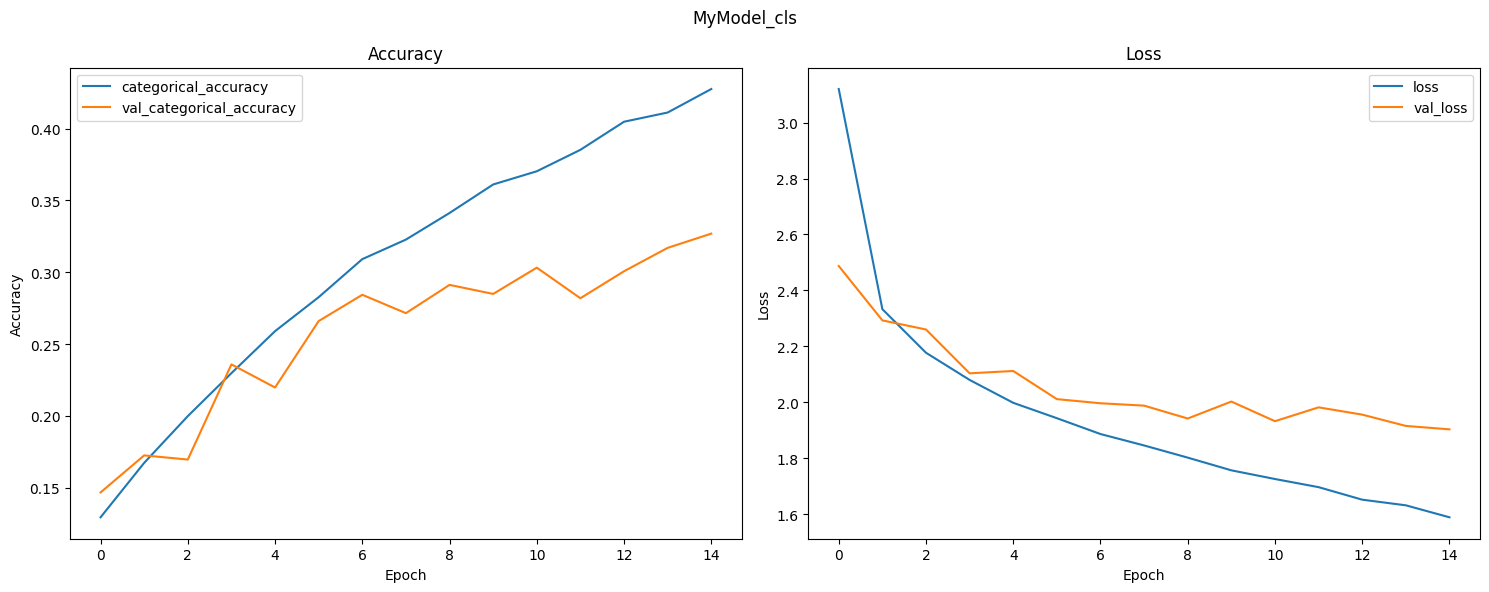

In [ ]:
my_model.print_logs()

## 2. with class weights and dropout

In [ ]:
my_model_drop = ImageEmotionClassifier()
my_model_drop(path=path, model_name="MyModel", augmentation=False, use_class_weights=True, dropout=True)
my_model_drop.create_model()
my_model_drop.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


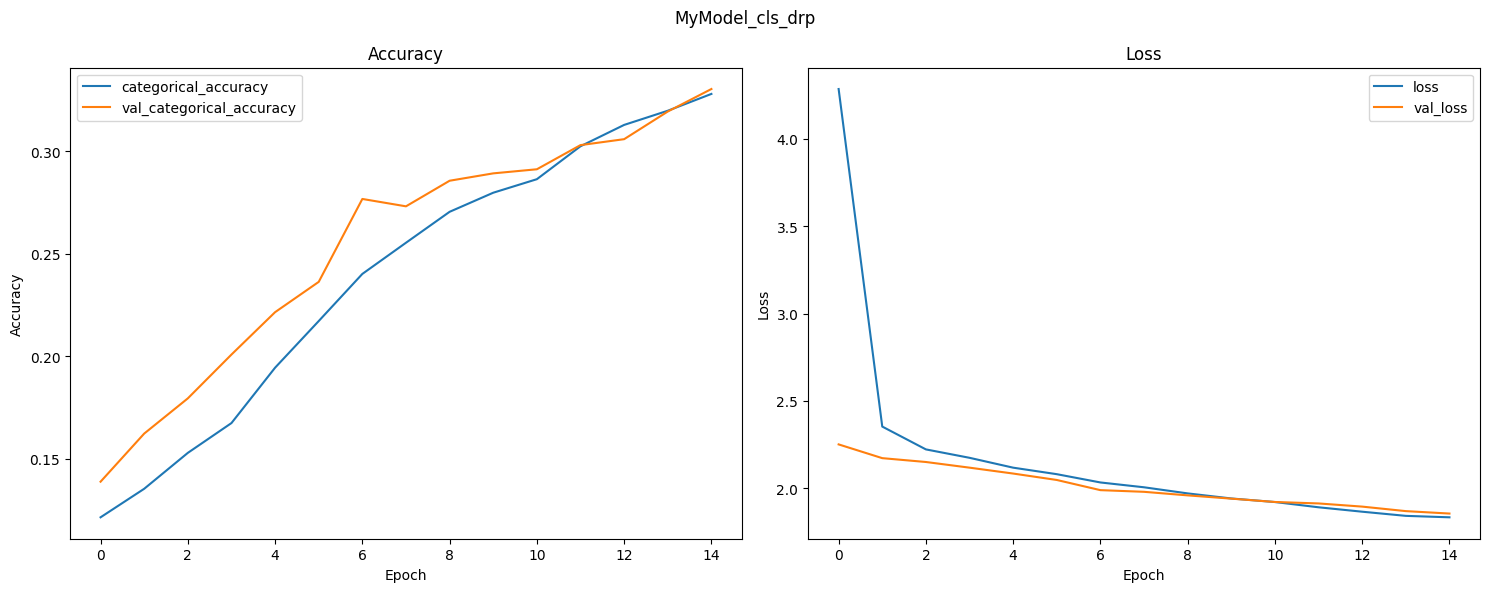

In [ ]:
my_model_drop.print_logs()

## 3. with class weights and two dropouts

In [ ]:
my_model_drop_2 = ImageEmotionClassifier()
my_model_drop_2(path=path, model_name="MyModel", augmentation=False, use_class_weights=True, dropout=True, dropout_2=True)
my_model_drop_2.create_model()
my_model_drop_2.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


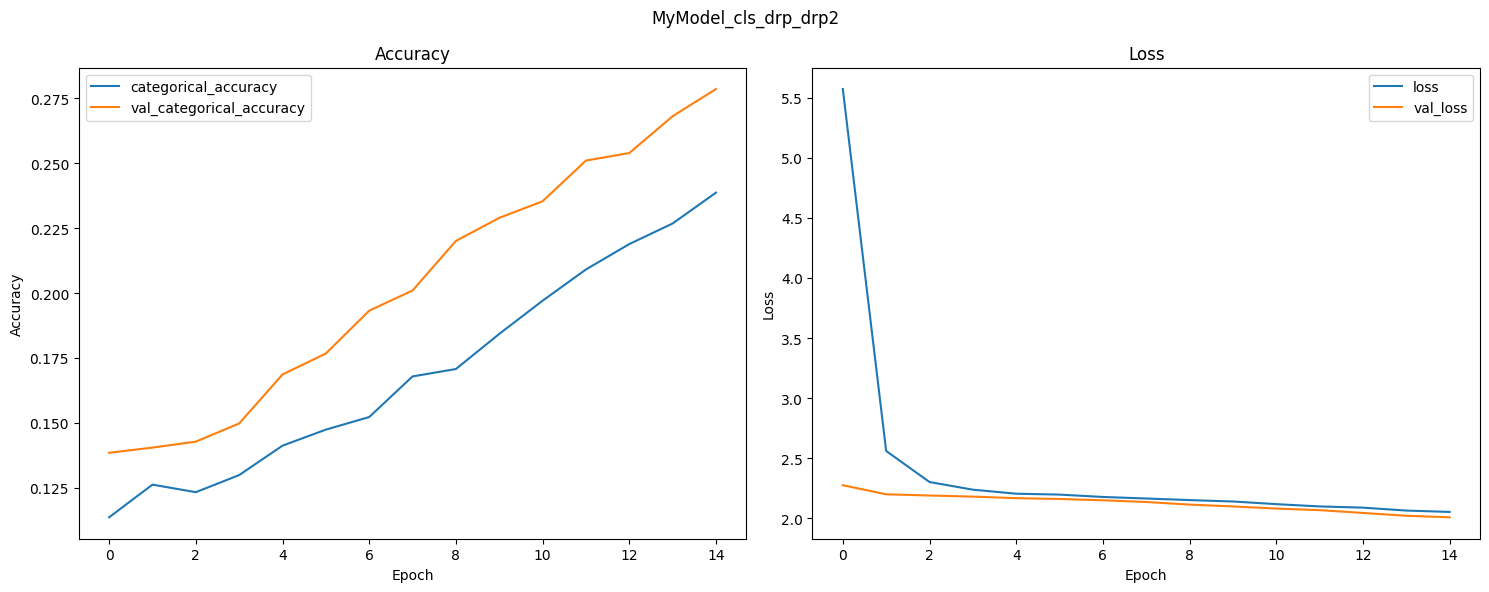

In [ ]:
my_model_drop_2.print_logs()

## 4. with augmentation and class weights

In [ ]:
my_model_plus_augm = ImageEmotionClassifier()
my_model_plus_augm(path=path, model_name="MyModel", augmentation=True, use_class_weights=True)
my_model_plus_augm.create_model()
my_model_plus_augm.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


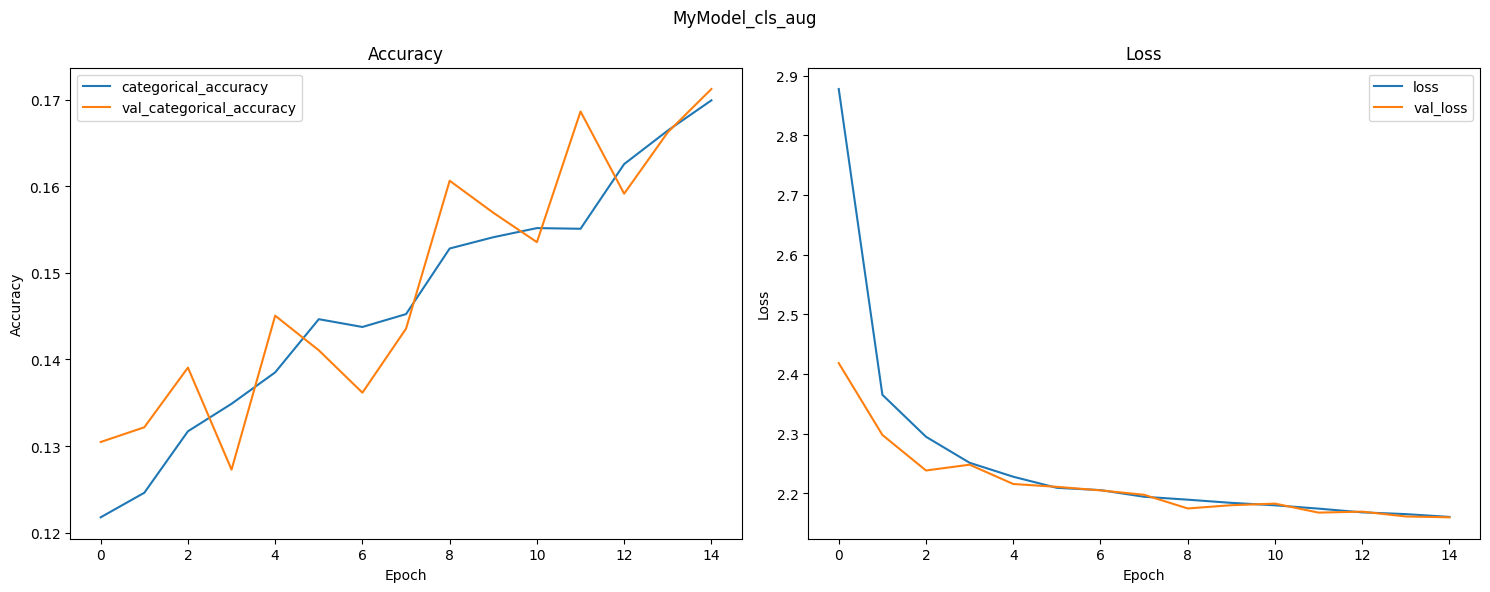

In [ ]:
my_model_plus_augm.print_logs()

## 5. with augmentation

In [ ]:
my_model_plus_augm_minus_class = ImageEmotionClassifier()
my_model_plus_augm_minus_class(path=path, model_name="MyModel", augmentation=True, use_class_weights=False)
my_model_plus_augm_minus_class.create_model()
my_model_plus_augm_minus_class.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


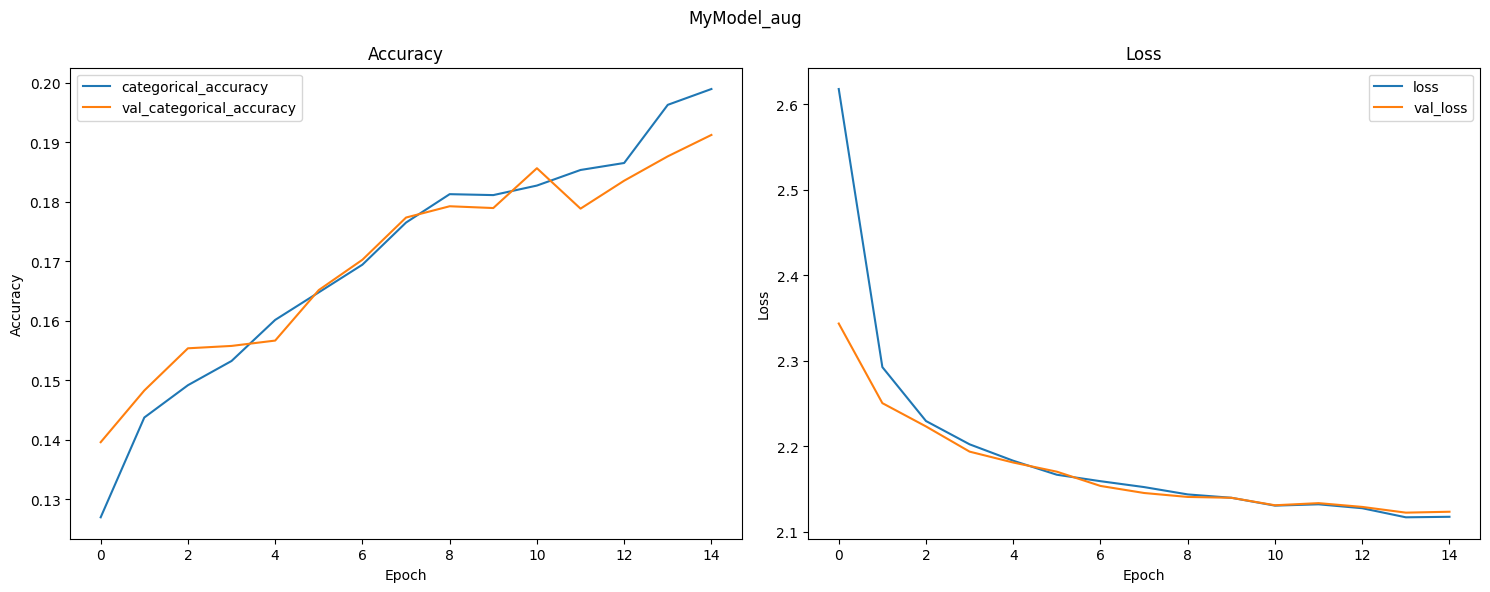

In [ ]:
my_model_plus_augm_minus_class.print_logs()

## 6. with augmentation and dropout

In [ ]:
my_model_plus_augm_minus_class_drop = ImageEmotionClassifier()
my_model_plus_augm_minus_class_drop(path=path, model_name="MyModel", augmentation=True, use_class_weights=False, dropout=True)
my_model_plus_augm_minus_class_drop.create_model()
my_model_plus_augm_minus_class_drop.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


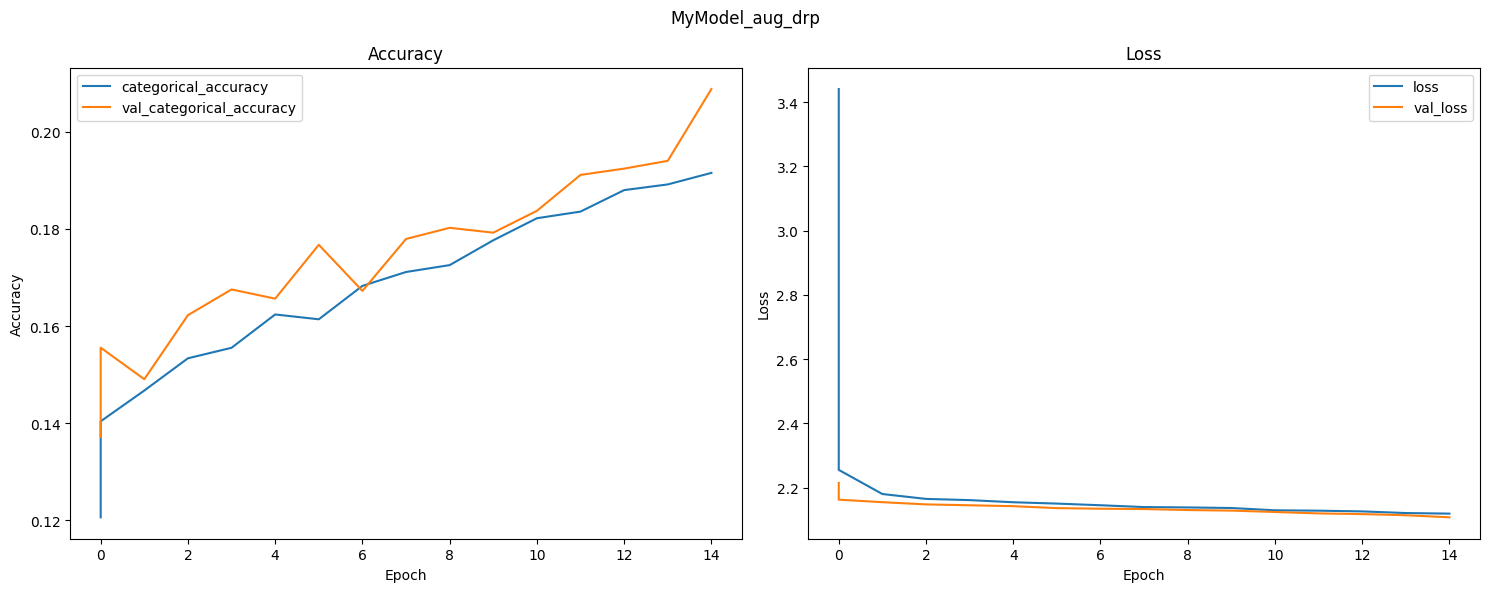

In [ ]:
my_model_plus_augm_minus_class_drop.print_logs()

# Custom model v.2

## 7. MyModel superior with weight classes and dropout

In [6]:
my_model_sup_drop = ImageEmotionClassifier()
my_model_sup_drop(path=path, model_name="MyModel_superior", augmentation=False, use_class_weights=True, dropout=True)
my_model_sup_drop.create_model()
my_model_sup_drop.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


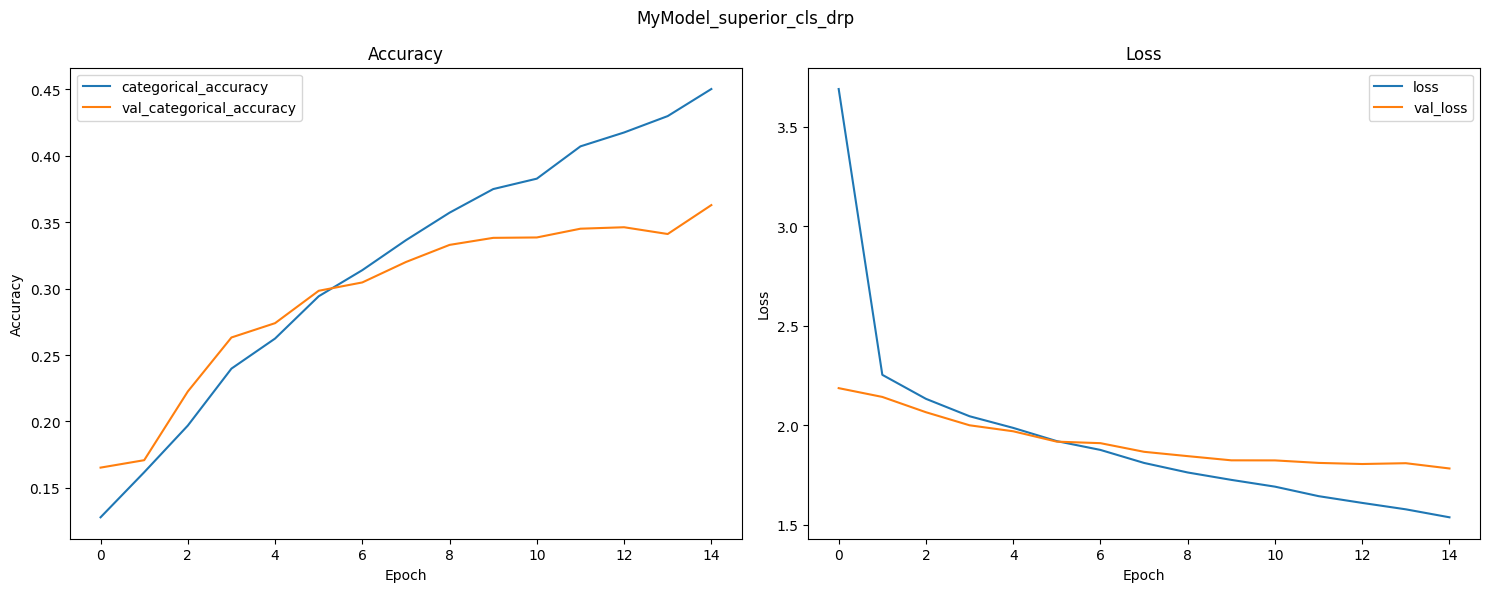

In [7]:
my_model_sup_drop.print_logs()

## 8. MyModel superior with weight classes and two dropouts

In [8]:
my_model_sup_drop_2 = ImageEmotionClassifier()
my_model_sup_drop_2(path=path, model_name="MyModel_superior", augmentation=False, use_class_weights=True, dropout=True, dropout_2=True)
my_model_sup_drop_2.create_model()
my_model_sup_drop_2.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


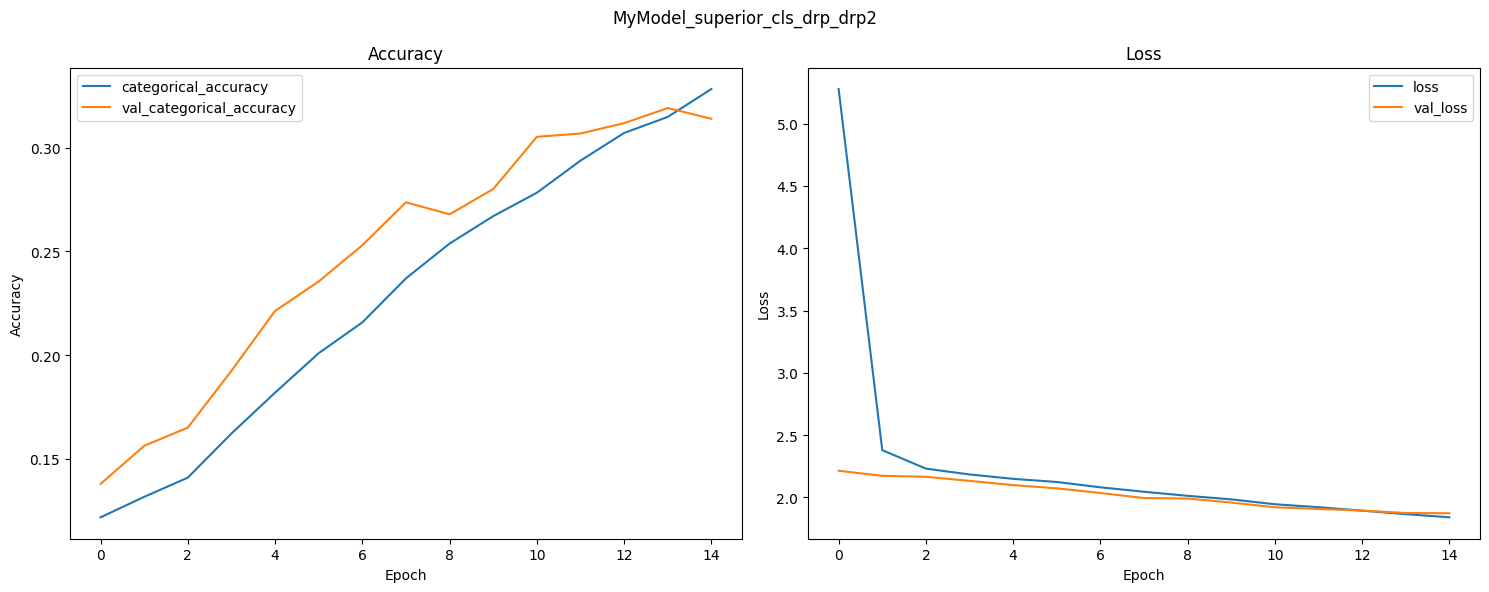

In [9]:
my_model_sup_drop_2.print_logs()

## 9. MyModel superior with augmentation and dropout

In [ ]:
my_model_sup_aug_drop = ImageEmotionClassifier()
my_model_sup_aug_drop(path=path, model_name="MyModel_superior", augmentation=True, use_class_weights=False, dropout=True, dropout_2=False, regularizers=False)
my_model_sup_aug_drop.create_model()
my_model_sup_aug_drop.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


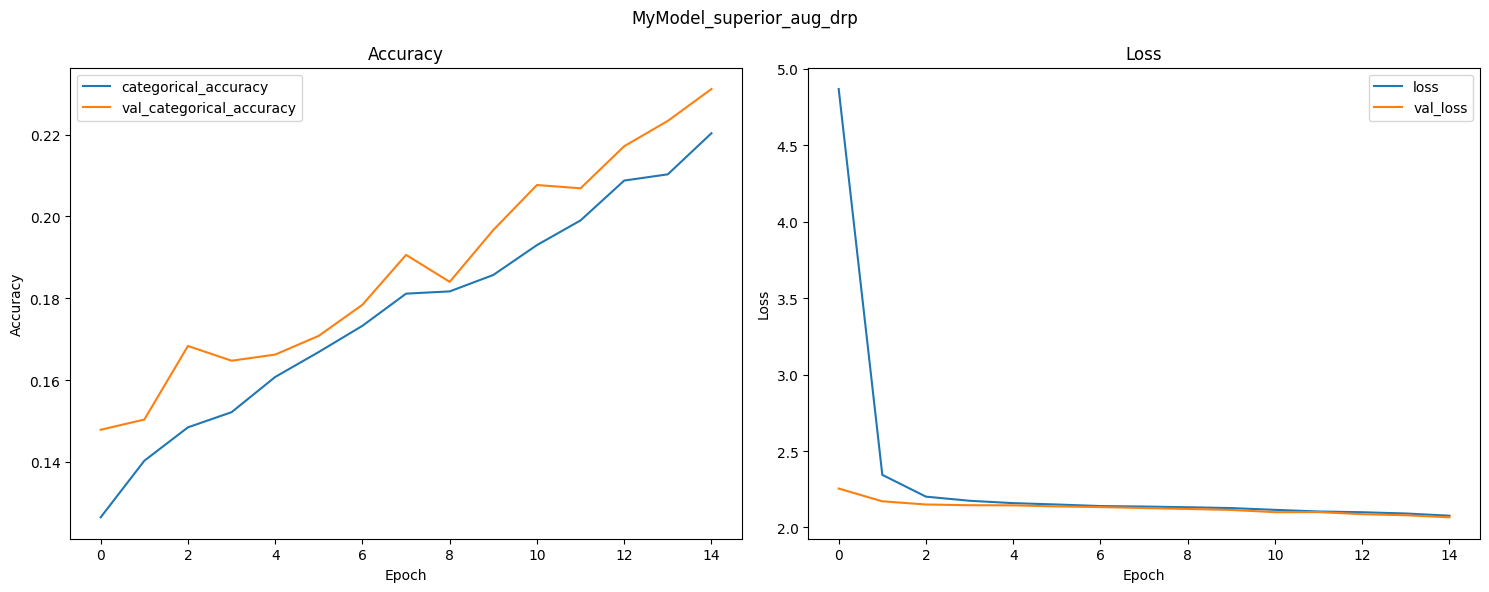

In [ ]:
my_model_sup_aug_drop.print_logs()

## 10. MyModel superior with augmentation and dropout and regularizers

In [ ]:
my_model_sup_aug_drop_reg = ImageEmotionClassifier()
my_model_sup_aug_drop_reg(path=path, model_name="MyModel_superior", augmentation=True, use_class_weights=False, dropout=True, dropout_2=False, regularizers=True)
my_model_sup_aug_drop_reg.create_model()
my_model_sup_aug_drop_reg.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


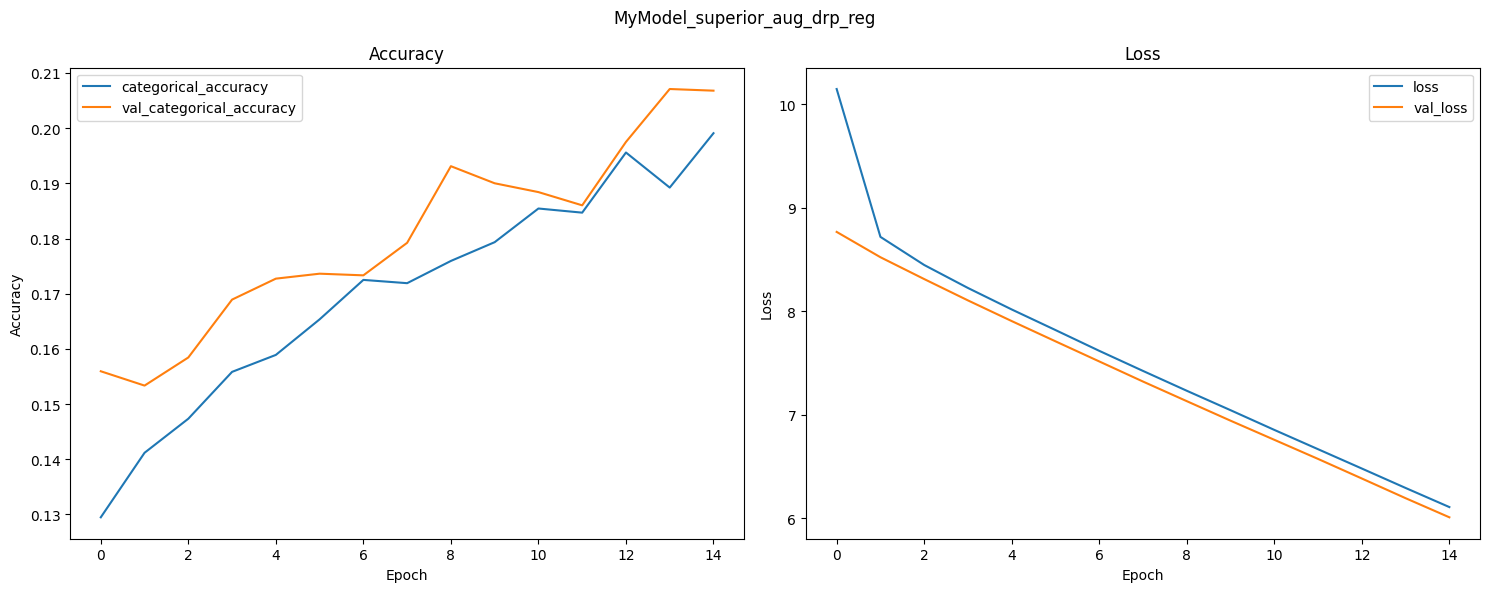

In [ ]:
my_model_sup_aug_drop_reg.print_logs()

# ResNet50 model

## 11. with class weights

In [ ]:
resnet_model = ImageEmotionClassifier()
resnet_model(path=path, model_name="ResNet50", augmentation=False, use_class_weights=True)
resnet_model.create_model()
resnet_model.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


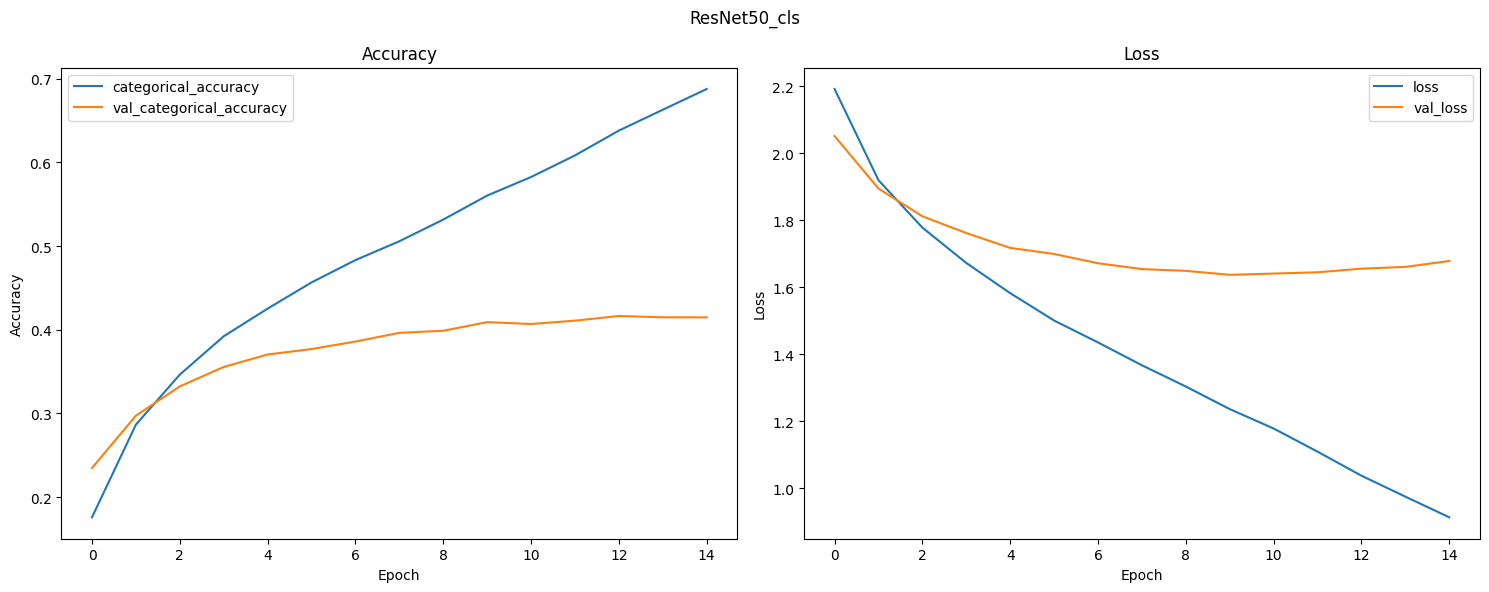

In [ ]:
resnet_model.print_logs()

## 12. with class weights and dropout

In [ ]:
resnet_model_drop = ImageEmotionClassifier()
resnet_model_drop(path=path, model_name="ResNet50", augmentation=False, use_class_weights=True, dropout=True)
resnet_model_drop.create_model()
resnet_model_drop.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


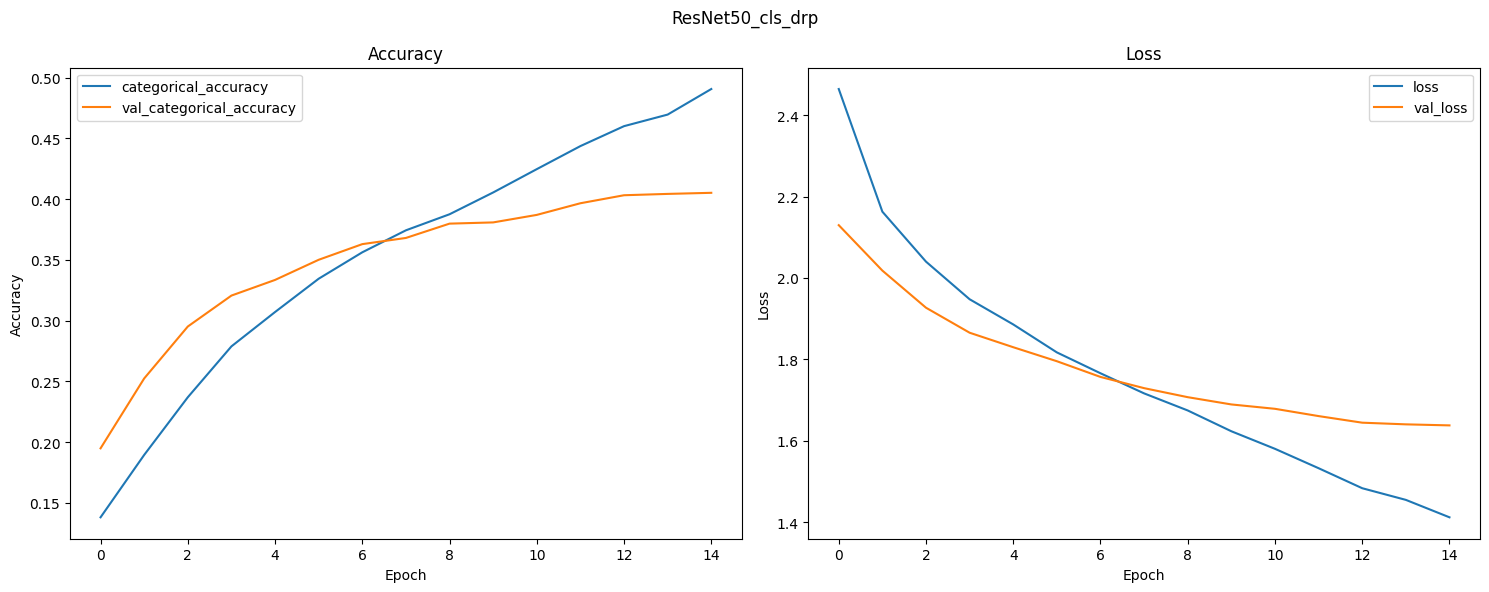

In [ ]:
resnet_model_drop.print_logs()

## 13. with augmentation and class weights and dropout

In [ ]:
resnet_model_plus_augm = ImageEmotionClassifier()
resnet_model_plus_augm(path=path, model_name="ResNet50", augmentation=True, use_class_weights=True, dropout=True)
resnet_model_plus_augm.create_model()
resnet_model_plus_augm.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


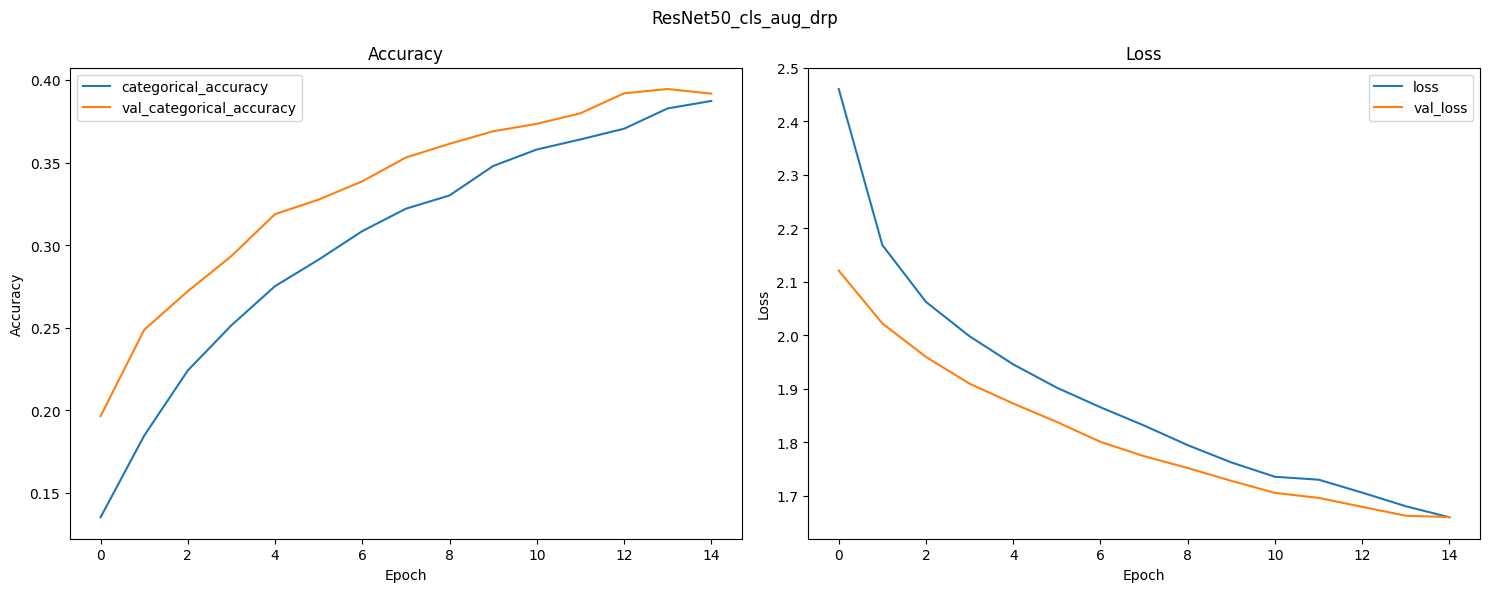

In [ ]:
resnet_model_plus_augm.print_logs()

## 14. with augmentation

In [ ]:
resnet_model_plus_augm_minus_class = ImageEmotionClassifier()
resnet_model_plus_augm_minus_class(path=path, model_name="ResNet50", augmentation=True, use_class_weights=False)
resnet_model_plus_augm_minus_class.create_model()
resnet_model_plus_augm_minus_class.train_model(epochs=15, steps=200, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


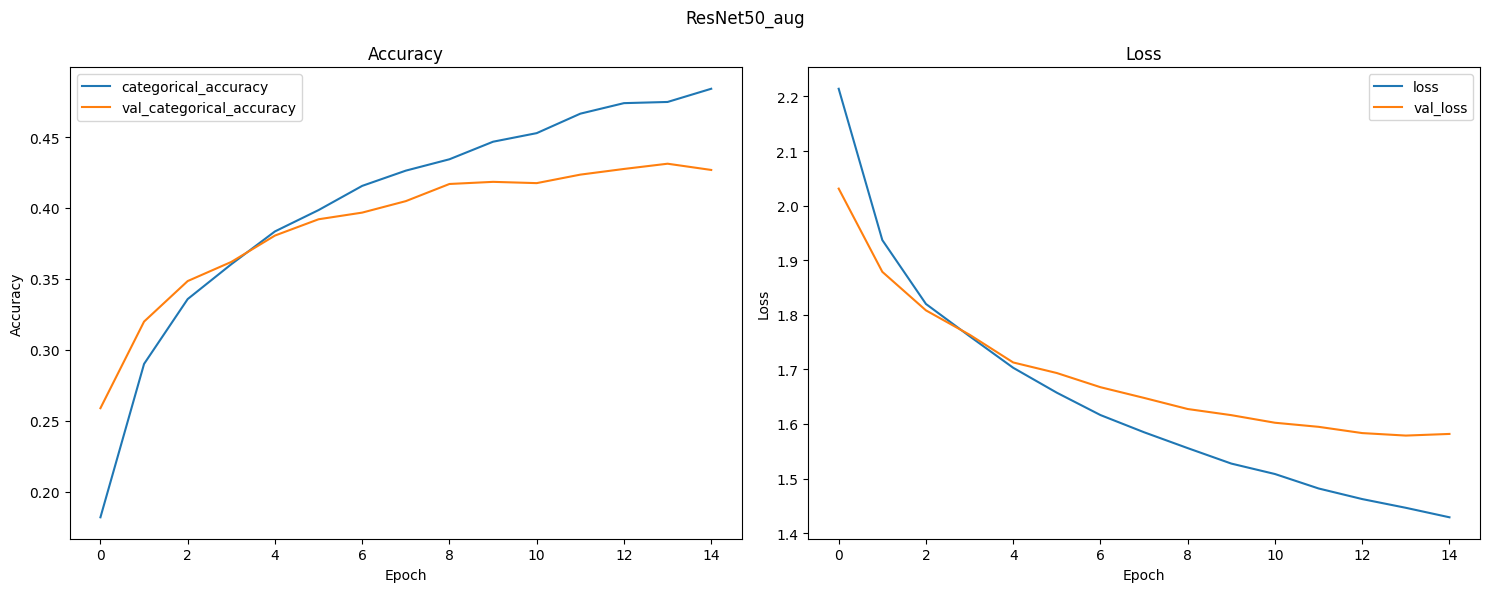

In [ ]:
resnet_model_plus_augm_minus_class.print_logs()

## 15. with augmentation and dropout

In [ ]:
resnet_model_plus_aug_drp = ImageEmotionClassifier()
resnet_model_plus_aug_drp(path=path, model_name="ResNet50", augmentation=True, use_class_weights=False, dropout=True)
resnet_model_plus_aug_drp.create_model()
resnet_model_plus_aug_drp.train_model(epochs=15, steps=200, batch_size=128)

94765736/94765736 [==============================] - 1s 0us/step
Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


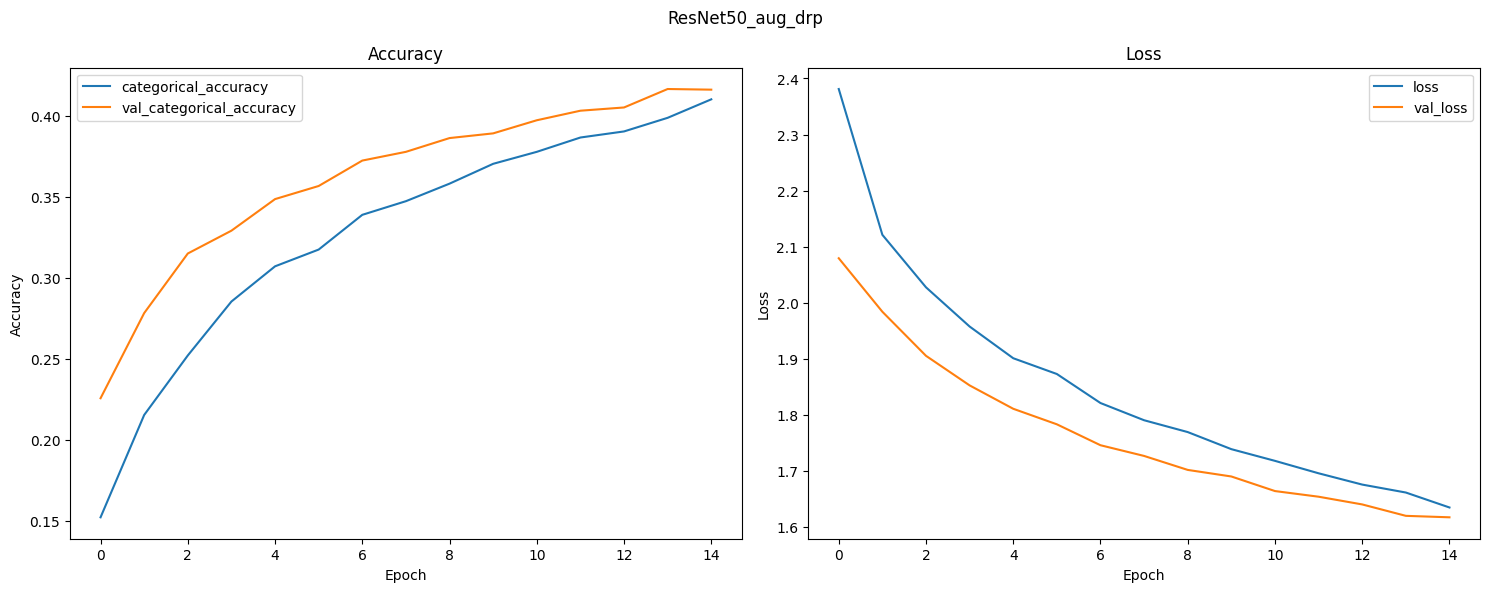

In [ ]:
resnet_model_plus_aug_drp.print_logs()

In [ ]:
resnet_model = ImageEmotionClassifier()
resnet_model(path=path, model_name="ResNet50", augmentation=False, use_class_weights=False, dropout=False)
resnet_model.create_model()
resnet_model.train_model(epochs=15, steps=200, batch_size=128)

94765736/94765736 [==============================] - 0s 0us/step
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 40036 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 10010 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


This model is already trained


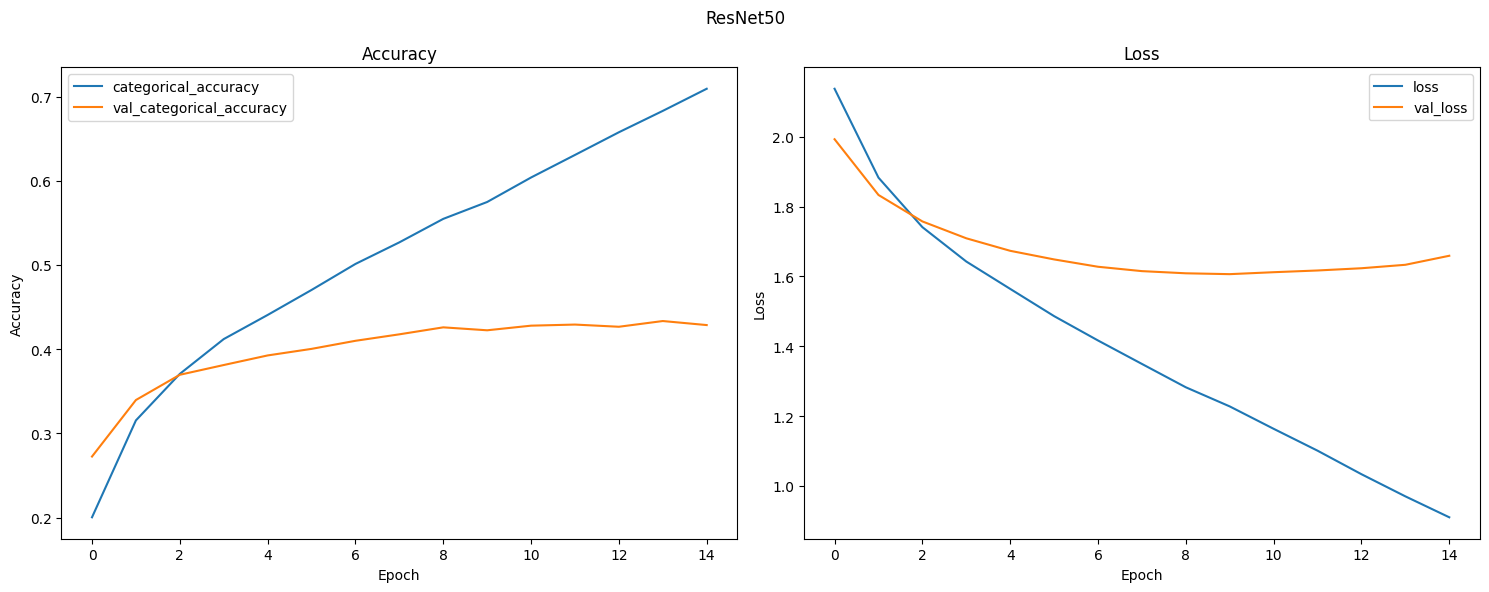

In [ ]:
resnet_model.print_logs()

In [ ]:
resnet_model_drp = ImageEmotionClassifier()
resnet_model_drp(path=path, model_name="ResNet50", augmentation=False, use_class_weights=False, dropout=True)
resnet_model_drp.create_model()
resnet_model_drp.train_model(epochs=15, steps=200, batch_size=128)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
This model is already trained


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 40036 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 10010 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


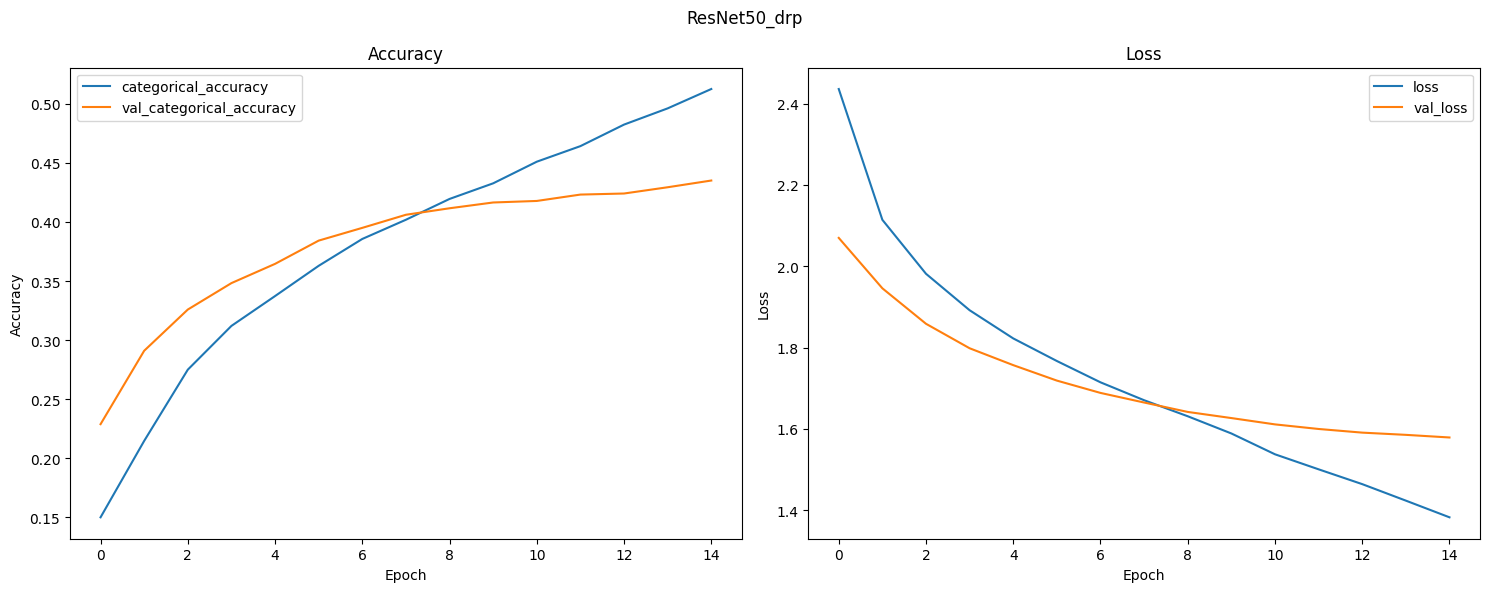

In [ ]:
resnet_model_drp.print_logs()

In [14]:
resnet_model_drp = ImageEmotionClassifier()
resnet_model_drp(path=path, model_name="ResNet50", augmentation=False, use_class_weights=False, dropout=True, dropout_2=True)
resnet_model_drp.create_model()
resnet_model_drp.train_model(epochs=15, steps=400, batch_size=128)

Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.
This model is already trained


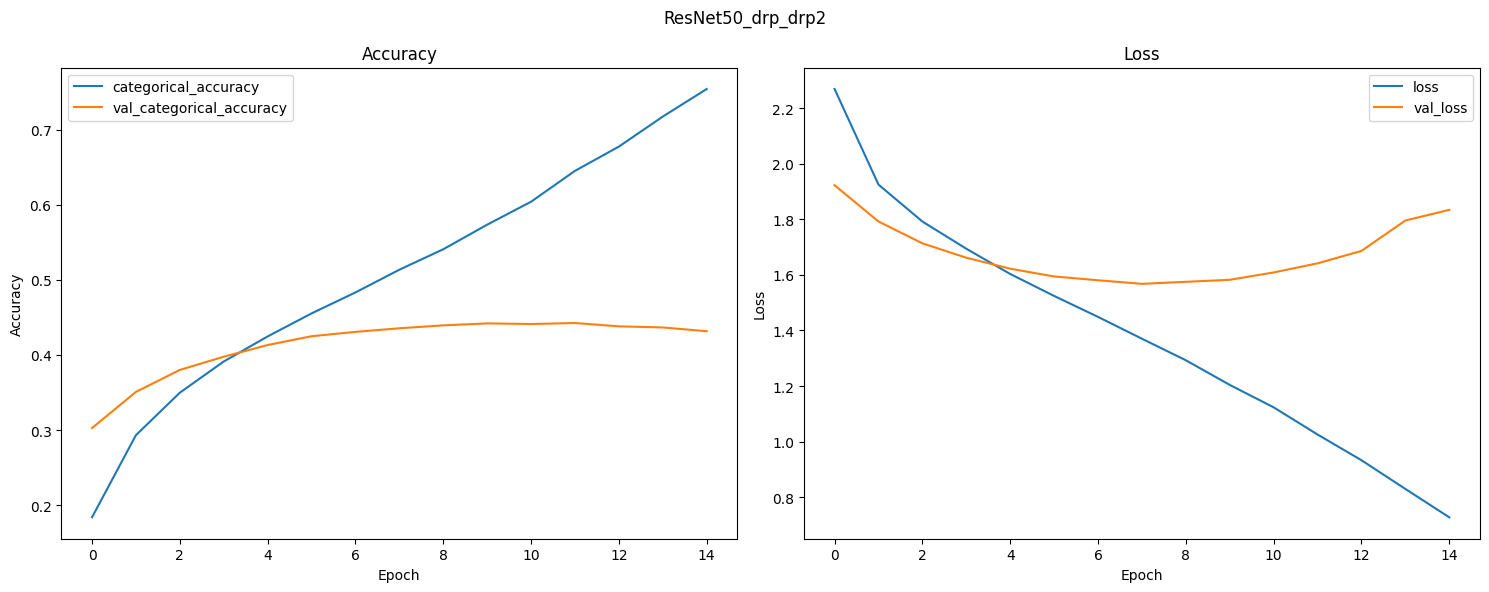

In [ ]:
resnet_model_drp.print_logs()

In [15]:
resnet_model_drp.restore_best_model()

In [16]:
resnet_model_drp.save_as_best()